<a href="https://colab.research.google.com/github/mneedham/data-science-training/blob/master/02_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis

In this notebook we're going to explore the citation dataset. We should already have installed py2neo, pandas, and matplotlib when setting up our environment, so let's get those imported:

In [ ]:
from py2neo import Graph
import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Now we need to create a connection to our Neo4j Sandbox. 

<div align="left">
    <img src="images/sandbox-citations2.png" alt="Neo4j 3.4 Sandbox"/>
</div>

We'll need to update the cell below to use the IP Address, Bolt Port, and Password.

In [ ]:
# Change the line of code below to use the IP Address, Bolt Port, and Password of your Sandbox.
# graph = Graph("bolt://<IP Address>:<Bolt Port>", auth=("neo4j", "<Password>")) 
 
graph = Graph("bolt://34.239.255.86:34057", auth=("neo4j", "swords-measurements-routines")

## What's in our database?

Now we can run the following query to check how many nodes our database contains:

In [ ]:
graph.run("CALL db.schema()").data()

If we run that query in the Neo4j Browser, we'll see the following visualisation:

<img src="images/data-science-training.png" alt="Graph Data Model"/>


Let's drill down a bit. How many nodes do we have for each of these labels?

In [22]:
result = {"label": [], "count": []}
for label in graph.run("CALL db.labels()").to_series():
    query = f"MATCH (:`{label}`) RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["label"].append(label)
    result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

,label,count
2,Venue,4
0,Article,51956
1,Author,80299


We can visualize the counts using matplotlib with the following code:

In [ ]:
nodes_df.plot(kind='bar', x='label', y='count', legend=None, title="Node Cardinalities")
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

And what types of relationships do we have?

In [ ]:
result = {"relType": [], "count": []}
for relationship_type in graph.run("CALL db.relationshipTypes()").to_series():
    query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["relType"].append(relationship_type)
    result["count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("count")

We can visualize the counts using matplotlib with the following code:

In [ ]:
rels_df.plot(kind='bar', x='relType', y='count', legend=None, title="Relationship Cardinalities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Now let's explore the citation data. The following query finds 25 authors, articles, venues, and also shows the number of articles that article has cited, as well as the number of articles that it's been cited by.

In [ ]:
exploratory_query = """
MATCH (author:Author)<-[:AUTHOR]-(article:Article)-[:VENUE]->(venue)
RETURN article.title AS article, author.name AS author, venue.name AS venue, 
       size((article)-[:CITED]->()) AS citationsGiven, size((article)<-[:CITED]-()) AS citationsReceived
ORDER BY rand()
LIMIT 25
"""

graph.run(exploratory_query).to_data_frame()

Let's look into the citation data more closely. We'll write a query that returns the number of citations that each article has, and then create a distribution of those counts using pandas `describe` function:

In [20]:
query = """
MATCH (a:Article)
RETURN size((a)<-[:CITED]-()) AS citations
"""

citation_df = graph.run(query).to_data_frame()
citation_df.describe([.25, .5, .75, .9, .99])

,citations
count,51956.000
mean,0.553
std,2.418
min,0.000
25%,0.000
50%,0.000
75%,0.000
90%,1.000
99%,8.000
max,211.000


Most articles are being cited very few times. 99% of articles have 1 citation or less. We do, however, have one article that's been cited more than 200 times. We'll use a log scale histogram to visualise the data;

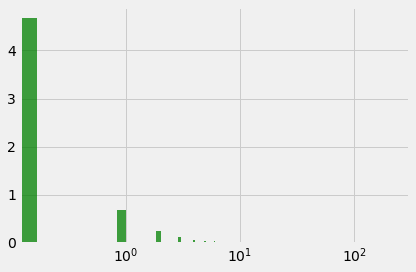

In [21]:
fig1, ax1 = plt.subplots()
ax1.hist(pd.Series(citation_df['citations'].dropna()), 1250, density=True, facecolor='g', alpha=0.75)
ax1.set_xscale("log")
plt.tight_layout()
plt.show()

## Exercise

* Can you create a similar chart showing the articles that cite the most other papers? Note that you'll only need to do a slight tweak of the Cypher query to do this. 
* What about a distribution of the number of articles published by authors?

Keep the results of these exercises handy as they form part of the Check your understanding quiz at the end of this module.